# Creating atmospheric forcing

In [2]:
from roms_tools import Grid, AtmosphericForcing

As always, the first step is to create our grid.

In [3]:
grid = Grid(
    nx=100, ny=100, size_x=2000, size_y=2400, center_lon=-18, center_lat=33, rot=-20
)

Next, we specify the temporal range that we want to make the atmospheric forcing for.

In [4]:
from datetime import datetime

In [5]:
start_time = datetime(2012, 1, 15)
end_time = datetime(2012, 3, 15)

For the time being, `ROMS-Tools` can only interpolate atmospheric forcing fields from ERA5. The user is expected to have downloaded the ERA5 data spanning the desired ROMS domain and temporal range from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form). Our downloaded data sits at the following location.

In [6]:
filename = "/glade/derecho/scratch/bachman/ERA5/NA/ERA5*"

We now create an instance of the `AtmosphericForcing` class.

In [7]:
%%time
forcing = AtmosphericForcing(
    grid=grid,  # Object representing the grid information.
    use_coarse_grid=False,  # Whether to interpolate to coarsened grid. Default is False.
    start_time=start_time,  # Start time of the desired forcing data.
    end_time=end_time,  # End time of the desired forcing data.
    source="era5",  # Source of the atmospheric forcing data. Default is "era5".
    filename=filename,  # Path to the atmospheric forcing source data file. Can contain wildcards.
)

CPU times: user 7.54 s, sys: 375 ms, total: 7.91 s
Wall time: 10.8 s


All atmospheric forcing fields necessary to run a ROMS simulation are now contained as `dask.arrays` within an `xarray.Dataset`. This dataset is accessible via the `.ds` property. All data operations are performed lazily, meaning that the atmospheric forcing fields have not been actually computed yet. Full computation will not be triggered until the `.save` method is called.

In [8]:
forcing.ds

<xarray.Dataset> Size: 420MB
Dimensions:  (time: 1439, eta_rho: 102, xi_rho: 102)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2012-01-15T01:00:00 ... 2012-03-14T23...
    lat_rho  (eta_rho, xi_rho) float64 83kB 25.23 25.19 25.14 ... 39.14 39.05
    lon_rho  (eta_rho, xi_rho) float64 83kB 328.4 328.6 328.8 ... 357.7 357.9
    lon      (eta_rho, xi_rho) float64 83kB -31.57 -31.37 ... -2.343 -2.144
    lat      (eta_rho, xi_rho) float64 83kB 25.23 25.19 25.14 ... 39.14 39.05
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad    (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad    (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    Title:    ROMS bulk surface forcing file produced by roms-tools

`ROMS-Tools` has found 1439 time stamps within our specified time range. Let's double-check that `ROMS-Tools` has selected the correct times.

In [9]:
forcing.ds.time

<xarray.DataArray 'time' (time: 1439)> Size: 12kB
array(['2012-01-15T01:00:00.000000000', '2012-01-15T02:00:00.000000000',
       '2012-01-15T03:00:00.000000000', ..., '2012-03-14T21:00:00.000000000',
       '2012-03-14T22:00:00.000000000', '2012-03-14T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 2012-01-15T01:00:00 ... 2012-03-14T23...

We make two observations:

1. The end date March 15, 2012 that we selected above is not included in the data. To include March 15, you must set the end date to March 16.
2. The ERA5 data provided to `ROMS-Tools` has an hourly resolution; this temporal resolution is inherited by `forcing.ds`.

To visualize any of the atmospheric forcing fields, we can use the `.plot` method.

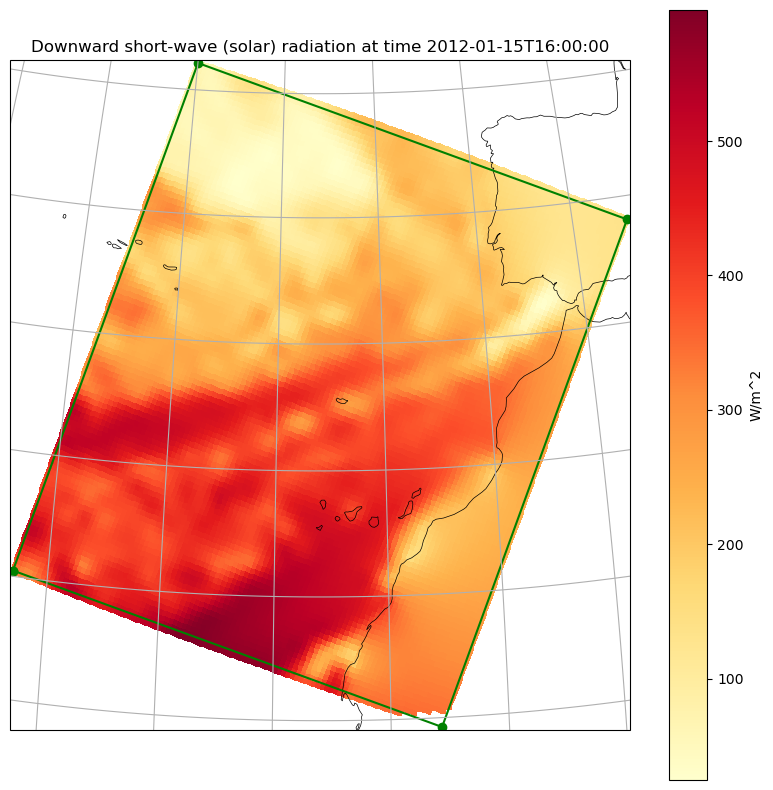

In [10]:
forcing.plot("swrad", time=15)

## Shortwave radiation correction

There is a consensus that global data products such as ERA5 have biases in radiation due to uncertain cloud-radiative feedbacks. `ROMS-Tools` has the ability to correct for these biases.

Outside of `ROMS-Tools`, we have prepared a global dataset that contains multiplicative correction factors for the ERA5 shortwave radiation, obtained by comparing the COREv2 climatology to the ERA5 climatology. 

In [11]:
import pooch

correction_filename = pooch.retrieve(
    url="https://github.com/CWorthy-ocean/roms-tools-data/raw/main/SSR_correction.nc",
    known_hash="a170c1698e6cc2765b3f0bb51a18c6a979bc796ac3a4c014585aeede1f1f8ea0",
)
correction_filename

'/glade/u/home/noraloose/.cache/pooch/758c88f76c48d967d043f258c0f578d0-SSR_correction.nc'

In [12]:
import xarray as xr

ds = xr.open_dataset(correction_filename)
ds

<xarray.Dataset> Size: 100MB
Dimensions:    (longitude: 1440, latitude: 721, time: 12)
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) timedelta64[ns] 96B 15 days 12:00:00 ... 349 days 12:00:00
Data variables:
    ssr_corr   (time, latitude, longitude) float64 100MB ...

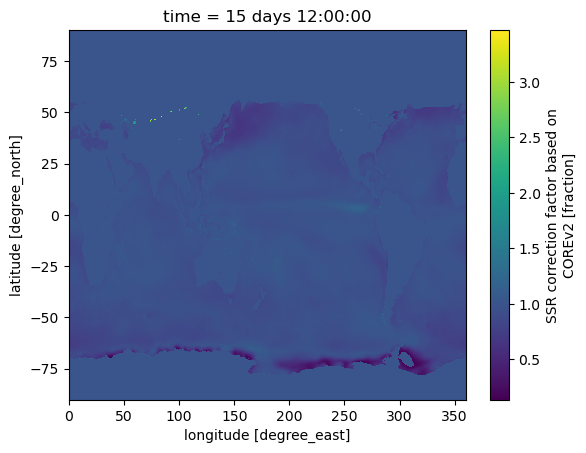

In [13]:
ds["ssr_corr"].isel(time=0).plot()

The correction factors cover the entire globe and are aligned with the ERA5 latitudes and longitudes. There are 12 time entries, corresponding to each month. You can either create your own (regional or global) dataset with multiplicative correction factors or use the one that we downloaded three cells above. The correction dataset is used by the `SWRCorrection` class.

In [14]:
from roms_tools import SWRCorrection

In [15]:
correction = SWRCorrection(
    filename=correction_filename,  # Filename of the correction data.
    varname="ssr_corr",  # Variable identifier for the correction.
    dim_names={
        "longitude": "longitude",
        "latitude": "latitude",
        "time": "time",
    },  # Dictionary specifying the names of dimensions in the dataset. Default is {"longitude": "lon", "latitude": "lat", "time": "time"}.
    temporal_resolution="climatology",  # Temporal resolution of the correction data. Default is "climatology".
)

A duplicate of the correction data can be seen by calling the `.ds` property. 

In [16]:
correction.ds

<xarray.Dataset> Size: 100MB
Dimensions:    (longitude: 1440, latitude: 721, time: 12)
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * time       (time) timedelta64[ns] 96B 15 days 12:00:00 ... 349 days 12:00:00
Data variables:
    ssr_corr   (time, latitude, longitude) float64 100MB dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>

We are now ready to incorporate the correction factors into our forcing. `ROMS-Tools` will make sure to use the factors from the correct subregion of the globe.

In [17]:
%%time
corrected_forcing = AtmosphericForcing(
    grid=grid,
    use_coarse_grid=False,
    start_time=start_time,
    end_time=end_time,
    source="era5",
    filename=filename,
    swr_correction=correction,
)

CPU times: user 2.32 s, sys: 1.02 s, total: 3.35 s
Wall time: 4.27 s


Here is a plot of the downward short-wave radiation, as before, but now in its corrected version.

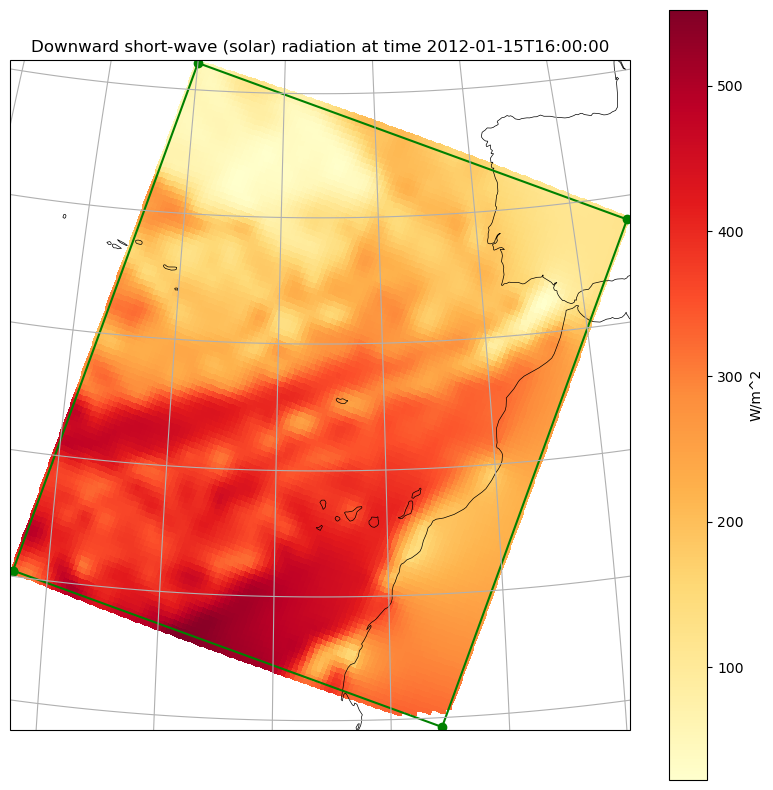

In [18]:
corrected_forcing.plot("swrad", time=15)

To visualize the difference between the corrected and uncorrected short-wave radiation, you can use `xarray`'s plotting method. 

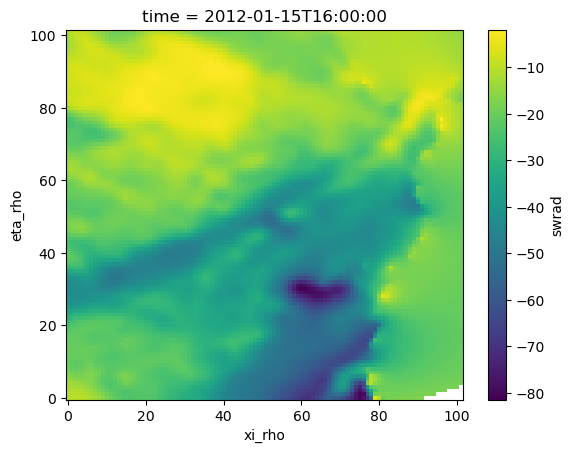

In [19]:
(corrected_forcing.ds - forcing.ds).swrad.isel(time=15).plot()

## Creating atmospheric forcing on a coarsened grid
To save computation time for creating the atmospheric forcing fields (i.e., when calling `.save` later), the user may want to only compute the forcing fields on a coarser grid. To this aim, the grid must first be coarsened by a factor of two via the `.coarsen` method.

In [20]:
grid.coarsen()

In [21]:
grid.ds

<xarray.Dataset> Size: 857kB
Dimensions:       (eta_rho: 102, xi_rho: 102, eta_coarse: 52, xi_coarse: 52)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 83kB 25.23 25.19 ... 39.14 39.05
    lon_rho       (eta_rho, xi_rho) float64 83kB 328.4 328.6 ... 357.7 357.9
Dimensions without coordinates: eta_rho, xi_rho, eta_coarse, xi_coarse
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 83kB -0.2498 -0.2498 ... -0.5257
    f             (eta_rho, xi_rho) float64 83kB 6.199e-05 ... 9.163e-05
    pm            (eta_rho, xi_rho) float64 83kB 4.22e-05 4.217e-05 ... 4.22e-05
    pn            (eta_rho, xi_rho) float64 83kB 5.04e-05 5.04e-05 ... 5.04e-05
    tra_lon       int64 8B -18
    tra_lat       int64 8B 33
    ...            ...
    h             (eta_rho, xi_rho) float64 83kB 5.257e+03 5.257e+03 ... 5.0 5.0
    lon_coarse    (eta_coarse, xi_coarse) float64 22kB 328.3 328.7 ... 358.0
    lat_coarse    (eta_coarse, xi_coarse) float64 22kB 25.15 25.06 ... 39.1
    h_coarse      (eta_coarse, xi_coarse) float64 22kB 5.257e+03 ... 5.0
    angle_coarse  (eta_coarse, xi_coarse) float64 22kB -0.2498 ... -0.5267
    mask_coarse   (eta_coarse, xi_coarse) int64 22kB 1 1 1 1 1 1 ... 0 0 0 0 0 0
Attributes:
    Type:               ROMS grid produced by roms-tools
    size_x:             2000
    size_y:             2400
    topography_source:  etopo5
    smooth_factor:      8
    hmin:               5.0
    rmax:               0.2

The dataset contained in `.ds` has now five new variables: `lon_coarse`, `lat_coarse`, `h_coarse`, `angle_coarse`, `mask_coarse`, which describe the same grid, but coarsened by a factor of two. The variables `lon_coarse` and `lat_coarse` are used for the interpolation if an instance of the `AtmosphericForcing` class is created with `use_coarse_grid = True`.

In [22]:
%%time
coarse_forcing = AtmosphericForcing(
    grid=grid,
    use_coarse_grid=True,
    start_time=start_time,
    end_time=end_time,
    source="era5",
    filename=filename,
    swr_correction=correction,
)

CPU times: user 2.14 s, sys: 258 ms, total: 2.39 s
Wall time: 2.53 s


In [23]:
coarse_forcing.ds

<xarray.Dataset> Size: 109MB
Dimensions:  (time: 1439, eta_rho: 52, xi_rho: 52)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2012-01-15T01:00:00 ... 2012-03-14T23...
    lon      (eta_rho, xi_rho) float64 22kB -31.69 -31.31 ... -2.374 -1.976
    lat      (eta_rho, xi_rho) float64 22kB 25.15 25.06 24.97 ... 39.28 39.1
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd     (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    vwnd     (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    swrad    (eta_rho, xi_rho, time) float32 16MB dask.array<chunksize=(52, 52, 1), meta=np.ndarray>
    lwrad    (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    Tair     (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    qair     (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    rain     (time, eta_rho, xi_rho) float32 16MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
Attributes:
    Title:    ROMS bulk surface forcing file produced by roms-tools

The atmospheric forcing fields now live on the coarsened grid. 

<div class="alert alert-info">

Note

The dimension names in `coarse_forcing.ds` are somewhat confusingly called `eta_rho`, `xi_rho` (rather than `eta_coarse`, `xi_coarse`). This is due to a particularity of ROMS - it expects the dimension names `eta_rho`, `xi_rho`. We should change this in the future! 

</div>

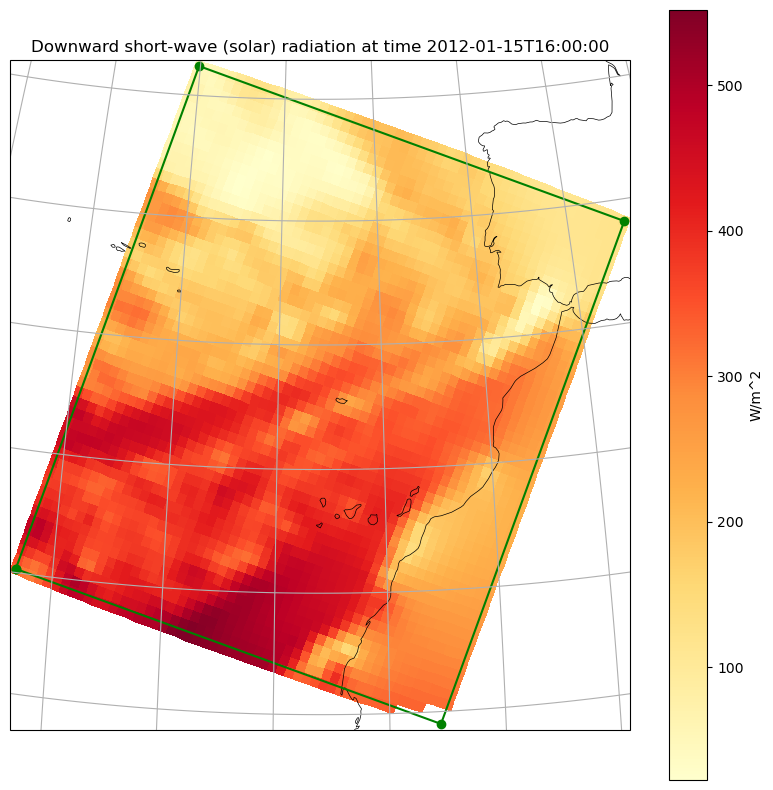

In [24]:
coarse_forcing.plot("swrad", time=15)

## Saving as NetCDF file
Once we have decided which of the atmospheric forcing versions we actually want to use, we can save the dataset as a series of NetCDF files.

We need to specify a desired target path.

In [25]:
path = "/glade/derecho/scratch/noraloose/forcing/frc"

We decided to save the corrected forcing on the fine grid. For our specified time range, we have 1439 time slices.

In [26]:
corrected_forcing.ds

<xarray.Dataset> Size: 420MB
Dimensions:  (time: 1439, eta_rho: 102, xi_rho: 102)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2012-01-15T01:00:00 ... 2012-03-14T23...
    lat_rho  (eta_rho, xi_rho) float64 83kB 25.23 25.19 25.14 ... 39.14 39.05
    lon_rho  (eta_rho, xi_rho) float64 83kB 328.4 328.6 328.8 ... 357.7 357.9
    lon      (eta_rho, xi_rho) float64 83kB -31.57 -31.37 ... -2.343 -2.144
    lat      (eta_rho, xi_rho) float64 83kB 25.23 25.19 25.14 ... 39.14 39.05
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad    (eta_rho, xi_rho, time) float32 60MB dask.array<chunksize=(102, 102, 1), meta=np.ndarray>
    lwrad    (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain     (time, eta_rho, xi_rho) float32 60MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    Title:    ROMS bulk surface forcing file produced by roms-tools

In [27]:
from dask.diagnostics import ProgressBar

In [28]:
with ProgressBar():
    %time corrected_forcing.save(path)

Saving the following files:
/glade/derecho/scratch/noraloose/forcing/frc.20120115-31.nc
/glade/derecho/scratch/noraloose/forcing/frc.201202.nc
/glade/derecho/scratch/noraloose/forcing/frc.20120301-14.nc
[########################################] | 100% Completed | 498.90 s
CPU times: user 6min 26s, sys: 43 s, total: 7min 9s
Wall time: 8min 27s


## Spinning up a customized dask cluster [UNDER CONSTRUCTION]

The above calculation utilized Dask's **single-machine**, thread-based default **scheduler**. If this option works well for your needs, that's great! However, you might encounter two potential issues:

1. The single-machine scheduler may not scale efficiently for large computations, such as processing multiple years of forcing data on a high-resolution ROMS grid.
2. Your Jupyter notebook kernel may crash due to running out of memory.

Both issues can be addressed by using Dask's **distributed scheduler**. The distributed scheduler can be run locally or distributed across a cluster. An overview of Dask schedulers can be found [here](https://docs.dask.org/en/stable/scheduling.html).

The following gives an example for how to run a Dask distributed scheduler locally.

In [29]:
from dask.distributed import LocalCluster

In [30]:
cluster = LocalCluster()
client = cluster.get_client()
client

/glade/work/noraloose/conda-envs/romstools-test/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38671 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/noraloose/proxy/38671/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/noraloose/proxy/38671/status,Workers: 1
Total threads: 1,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34099,Workers: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/noraloose/proxy/38671/status,Total threads: 1
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:39857,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/noraloose/proxy/40623/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:41775,


Since this jupyter notebook runs on a single core on casper, Dask has automatically chosen only a single worker and a single thread. Note that the cluster now operates process-based.

Let's repeat our calculation, but this time with the local Dask cluster.

In [31]:
%%time
corrected_forcing = AtmosphericForcing(
    grid=grid,
    use_coarse_grid=False,
    start_time=start_time,
    end_time=end_time,
    source="era5",
    filename=filename,
    swr_correction=correction,
)

CPU times: user 2.4 s, sys: 156 ms, total: 2.56 s
Wall time: 20.2 s


In [32]:
path = "/glade/derecho/scratch/noraloose/forcing/duplicated_frc"

In [33]:
%time corrected_forcing.save(path)

Saving the following files:
/glade/derecho/scratch/noraloose/forcing/duplicated_frc.20120115-31.nc
/glade/derecho/scratch/noraloose/forcing/duplicated_frc.201202.nc
/glade/derecho/scratch/noraloose/forcing/duplicated_frc.20120301-14.nc


/glade/work/noraloose/conda-envs/romstools-test/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 11.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 24s, sys: 5.46 s, total: 1min 29s
Wall time: 13min 33s


<div class="alert alert-info">

Note

If we had run this notebook on a CPU node on Perlmutter, the same `LocalCluster()` command would create a cluster with 16 workers, totaling 256 threads and 476.56 GiB of memory. 

Here are the Perlmutter execution times:

CPU times: user 2min 28s, sys: 1min 58s, total: 4min 26s

Wall time: 9min 59s

Note that on Perlmutter the default single-machine, thread-based default scheduler (the one above this section) does not work.
</div>